# Introduction
This document reports my decision making process throughout a data analysis work. The purchase data herein used was modified for client protection, whereas only the positional data was held untouched.

The positional data consists of tuples (#section, timestamp, stay_time), such as (104,1464752042,6), where informs that a person was detected on section 104, at the time 1464752042, and he/she spent 6 seconds there.

This document is organized in two sections:
1. Introduction, 
2. Data Analysis.

The introduction section presents the thought process behind the presented work, addressing the objectives targeted as well as the overall decision making process. While the following section walks through the decision proccess followed to sugest a new metric/pattern to the client, explaining the theoretical insights, as well as the intuition reflected on data.


# Data Analysis
A pre-processing stage is necessary since the data may present inconsistencies and decisions should be made to overcome them. 

### Data pre-processing

Several issues and inconsistencies were found in the provided data:

1. location tuples stating zero seconds of stay,
2. several identical tuples in the location.csv,
3. area 110 is not watched by the cameras,
4. some of the items are not being exposed in the watched areas.


To overcome the first issue, I simply removed from the dataset such tuples, since the main cause of this behaviour is unknown. Regarding the second issue, duplicated tuples can be thought as correct data, depending on the detection system's settings (such as the camera framerate, etc). But I chose to keep only unique values (drop out repetitive tuples, keeping on the dataset only one unique tuple for each instance), since the cause of the problem is also unknown.

For the third and fourth issues, the unwatched area as well as items were simply ignored, since no further information about them is available.

### Scalability
Most of the computation was done using pyspark framework (spark adapted for python) for scalability purposes.

### Approach to explore new insights
There are various possibilities to explore such dataset, employing, for example, unsupervised learning techniques (clustering commonly sold items, anomaly detection) or common exploratory data analysis.

There are innumerable possibilities to explore in such dataset, such as to cluster items commonly sold together, to evaluate cosely related items.

For this work, I focused on what I think builds up the most with the company's interests. In order to better assess the impact of promotional areas as well as the physical settings of the shopping environment, one can benefit from the knowledge of the physical disposition available as well as location data to evaluate how the areas are interacting with each other. Thus, making easier to evaluate the impact of a promotional site among different areas (including its vicinity). Also, it is easier to identify areas that might be underutilized. It will be explained in better details in the following sections.

Also, all three metrics (exposure, engagement power and conversion) are sensitive to the time-window used. Thus, they are also computed in function of a given time window, to better assess the impact of promotional events.

First, we need to import some packages and get some parse functions done to load the data





In [39]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import pyspark.sql.dataframe as df
import matplotlib.image as mpimg
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math

from IPython.html.widgets import *
from ipywidgets import widgets
from matplotlib import ticker
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#%matplotlib inline

#Function to parse a location string and return a python tuple
def split_location(loc_tuple):
    split = loc_tuple.split(',')
    #It should be returned as a tuple so it can be hashed: condition necessary to use .distinct() function.
    return (int(split[0]), int(split[1]), int(split[2]))

#Function to parse the sales string.
def split_sales(sales_tuple):
    split = sales_tuple.split(',')
    return (int(split[0]), int(split[1]), split[2], split[3], int(split[4]), float(split[5]))

#Function to parse the shelfs dictionary
def preproc_shelfs(x):
    j = json.loads(x)
    for x in j:
        for i,y in enumerate(j[x]):
            j[x][i] = int(y)
        j[int(x)] = j.pop(x)
    return j

#Function to shatter the dictionary in tuples
def shatter_dict(d):
    l = []
    for x in d:
        l.append((x,d[x]))
    return l




Now, we load the datasets using pyspark textfile function and the above written parse functions. Then, we do some pre-processing on the locations dataset to drop out tuples with zero valued stays and repetitive ones.

In [40]:
#Loading datasets
sales = sc.textFile('data/sales.csv').map(lambda sale: split_sales(sale))
area_sku_shattered = sc.textFile('data/shelfs.json').map(lambda x: preproc_shelfs(x)).flatMap(lambda x: shatter_dict(x))
locations = sc.textFile("data/location.csv").map(lambda t: split_location(t))

#Locations dataset has several repeated data: same location, same timestemp, same time spent. 
#Thus we require only distinct data to be computed

locations_distincts_zero_free = locations.filter(lambda x: x[2] > 0).distinct()

print('pre-processed locatin dataset: ',locations_distincts_zero_free.take(3))      


pre-processed locatin dataset:  [(101, 1464802470, 2), (100, 1464789394, 9), (106, 1464801576, 1)]


# Proposed metrics and insights
In order to visualize how the data behaves timewise, we need to choose a time window length. A long time-windows is usefull for getting overall knowledge and baseline comparissons but it fails to capture high-frequency events such as peaks and valleys.

Tracking the occurrences of peaks and valleys  would reveal valuable information regarding the behaviour of shoppers along time, aiding on prediction and planning of actions by both shoppers and sellers.

With that in mind, we are going to visualise the dataset looking for insights on how we could find a good time-window to work with. We plot the histogram of the location dataset to have an overview on the data distribution. The bins are divided timewisely, thus each bin represents how many people were detected in that time-window. For this visualisation, we simply divide the location dataset in $100$ equally spaced bins.

<IPython.core.display.Javascript object>


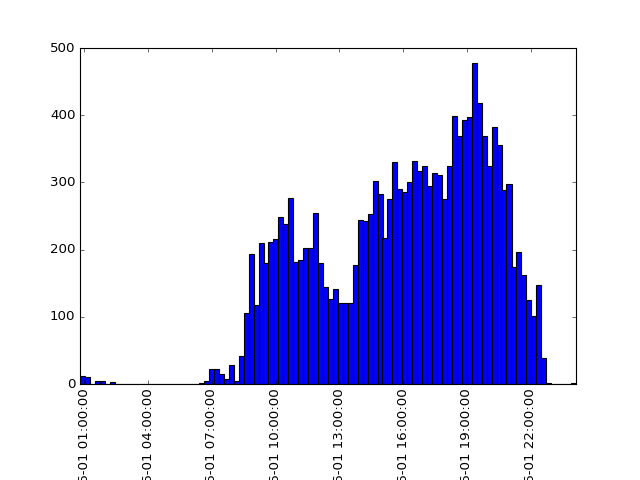

In [41]:
ts = locations_distincts_zero_free.map(lambda x: x[1]).histogram(100)

import datetime as dt
import matplotlib.dates as md

dates=[dt.datetime.fromtimestamp(t) for t in ts[0][1:]]

plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=90 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.bar(dates,ts[1],width = 0.01, color = 'b')
plt.show()

#We could use a histogram to compute the snapshots of the people distribution in function of time t. 
#We need to analyze how smooth the timestamp progression is, so we can think about the bucket size, and how
#to segmentate the data to better reflect the time-space correlation among areas
#We should also attempt to long time interval between analysis.

The above figure shows that the location data ranges from 01:00:00 to 22:00:00 of july 1st, where the most significant mass ranges from 09:00:00 to 22:00:00.

Thus, from now on, we consider only the portion of the dataset corresponding to the slice 09:00:00 to 22:00:00 of july 1st, which represents most of the shoppers activities.

Now we need to find a good time-window size to analyse the data. The ideal time-window size depends on what is being analysed: it should be large enough to fit the events that are being studied and small enough to avoid information loss.

First, lets see how the distribution of people exposition among areas varies along time. To do so, we need to choose a window size. Thus, we look first for the smallest size we could use. To compute this, we calculate the mean and standard deviation of the stay data: 

$$ \mu = \frac{1}{|S|}\sum_{i \in S}{i}$$

$$ \sigma = \sqrt{\frac{1}{|S| - 1}\sum_{i \in S}{(i - \mu)^2}} $$

In [42]:
start_time = dt.datetime(2016,6,1,9,00,00) 
start_time_ts = (start_time - dt.datetime(1970, 1, 1)) / dt.timedelta(seconds=1)

detections_filtered = locations_distincts_zero_free.filter(lambda x: x[1] >= start_time_ts)

total_stay_detections =     detections_filtered.map(lambda x: ('mean',(x[2],1))) \
                            .reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1])) \
                            .collect()[0]
                            
stay_detection = total_stay_detections
mean = stay_detection[1][0]/stay_detection[1][1]
print('stay mean: ', mean)
std = detections_filtered.map(lambda x: ('std', (x[2] - mean) ** 2)) \
                         .reduceByKey(lambda x,y: x+y) \
                         .map(lambda x: (x[0], math.sqrt(x[1]/ (stay_detection[1][1] -1)))) \
                         .collect()[0][1]
print('stay std: ', std)
print('stay interval (mean + 2std) = ', mean + 2*std)
        

stay mean:  5.09400419837313
stay std:  6.829380957922647
stay interval (mean + 2std) =  18.752766114218424


We found that using windows of size 18.21 seconds we can fit the vast majority of the detections. But using such a small window would require a huge amount of windows to cover 13 hours. Since we would like to manually look through the data looking for insights, we should enlarge the window size to make this possible. Five minutes long seems to be a reasonable window size, since it would require approximately 200 windows to cover 13 hours and 5 minutes is not long enough to suppress usefull information for our purpose.

Now, we are going to divide the location data into bins, every bin corresponding to $300$ seconds (5 minutes) and compute the histogram of people detections distributed over the areas.


In [43]:
d = dt.datetime(2016,6,1,9)
timestamp_threshold = (d - dt.datetime(1970, 1, 1)) / dt.timedelta(seconds=1)
grouped_area_ts = locations_distincts_zero_free.filter(lambda x: x[1] > timestamp_threshold).map(lambda x: (x[0],x[1])).groupByKey().map(lambda x: (x[0], list(x[1])))

start_time = dt.datetime(2016,6,1,9,00,00) 
start_time_ts = (start_time - dt.datetime(1970, 1, 1)) / dt.timedelta(seconds=1)

def get_bin(x,start,length,n_bins):
    b = int((x-start)/length)
    if b > n_bins-1:
        b = -1
    return b
def convert_ts_to_bins(x):
    n_bins = 210
    bins = [0] * n_bins
    
    length_seconds = 300
    idx = get_bin(x, start_time_ts, length_seconds, n_bins)
    if idx > 0:
        bins[idx] = 1
    return bins

def bins_to_ts(b):
    length_seconds = 300
    return dt.datetime.fromtimestamp(b * length_seconds + start_time_ts - length_seconds/2)

def sum_vecs(x,y):
    return [i+j for i,j in zip(x,y)]

histograms_rdd = detections_filtered.map(lambda x: (x[0], convert_ts_to_bins(x[1]))) \
                                    .reduceByKey(lambda x,y: sum_vecs(x,y))
histograms = histograms_rdd.collectAsMap()


For visualization purposes, lets plot the distributions using the blue print and a color map. For each area, we use different colors depending on how many detections there were in the current bin.

Lets also add a time bar, so we can slide to analyse how the distribution evolves with time.

<IPython.core.display.Javascript object>


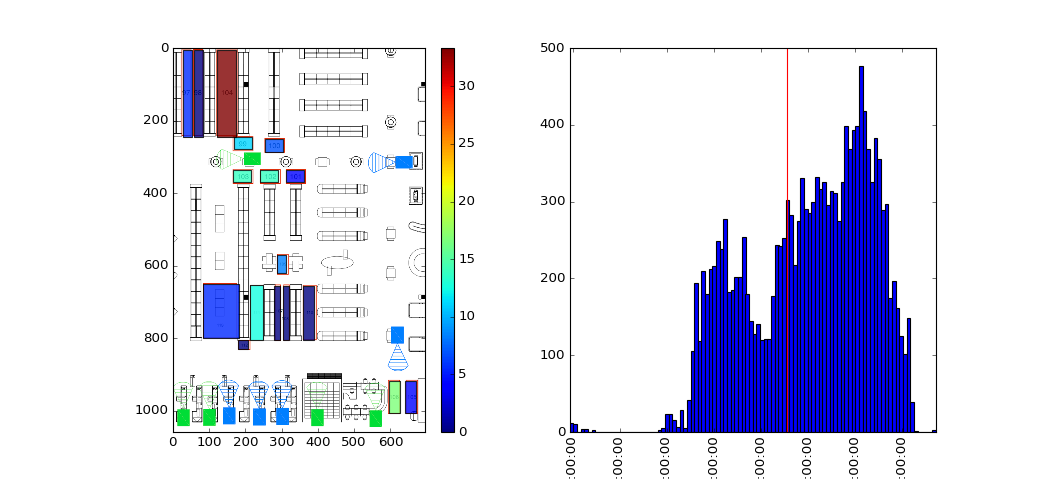

In [44]:

img = mpimg.imread('data/store_zoom.png')

#Image coordinates of the respective areas
area_rects = {
    97:((27,5), 25, 240),
    98:((57,5), 25, 240),
    99:((168, 244),50,35),
    100:((253, 250),50,35),
    101:((313, 335),50,35),   
    102:((240, 335),50,35),
    103: ((166, 335),50,35),
    104:((123, 5), 50, 240),
    105: ((640, 917),30,90),
    106: ((596, 917),30,90),
    107: ((280, 655),15,150),
    108: ((305, 655),15,150),
    109: ((287, 570),25,50),
    110: ((360, 655),30,150),
    111: ((213, 654),35,150),
    112: ((180, 806),28,23),
    113: ((83, 649),100,150)
}
#Function to draw each rect.
def draw_rects(ax, rects, c):
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=0, vmax=35)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    colorVal = scalarMap.to_rgba(35)
    rect_patches = []
    for i in rects:
        rect = plt.Rectangle(rects[i][0],rects[i][1],rects[i][2], color=colorVal)
        rect_patches.append(rect)
    p = PatchCollection(rect_patches, cmap=jet, alpha=0.8)
    ax.add_collection(p)
    return p

#Plot code
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=35)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

fig, (ax,ax2) = plt.subplots(1,2, figsize=(13, 6))

xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.xticks( rotation=90 )
ax2.xaxis.set_major_formatter(xfmt)
ax2.bar(dates,ts[1],width = 0.01, color = 'b')
vline = ax2.axvline(x=bins_to_ts(120), color = 'r')

rect_patches = draw_rects(ax,area_rects,'r')
img_plot = ax.imshow(img)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = plt.colorbar(img_plot,cmap = plt.get_cmap('jet'), orientation='vertical', norm=cNorm, cax=cax)
tick_locator = ticker.MaxNLocator(nbins=8)
cbar.locator = tick_locator
cbar.update_ticks()
ticks = [0,5,10,15,20,25,30,35]
cbar.ax.set_yticklabels(ticks)


import random
#Update function to interaction purpose.
def update(f):
    colors = [0] * 17
    for i,rect_n in zip(range(17),range(97,114)):
        if rect_n in histograms.keys():
            c = histograms[rect_n][f]
            colors[i] = c if c < 35 else 35
        else:
            c = 0
    print(colors)
    rect_patches.set_array(np.array(colors))
    vline.set_xdata(bins_to_ts(f))
    fig.canvas.draw()

#****************************************************************************************************
#To interact with the plot, please execute the next cell and then move the bar left or right.    ****
#****************************************************************************************************

In [45]:
interact(update, f=(0,209,1))

[4, 0, 8, 5, 3, 10, 10, 24, 3, 12, 0, 0, 6, 0, 9, 0, 4]


<function __main__.update>

We can check some interesting behavioural patterns analysing the graph above. For example, the areas located at the top  of the figure [99-104] presented the majority of detections. Also, the detections appear to present some positive correlation level: they usually present simillar levels of detections at a given time.

The same behaviour could not be checked for the bottom areas [107-113]. They seem to be little correlated to each other, despite the close distance between them.

This correlation notion reflects the behaviour of the shopper during the analysed time window. Since we are using a windows of 5 minutes long, high correlation between areas means that, along this 5 minutes, shoppers in a given area are likely to remain among highly correlated areas, specially if they are phisically close to each other.

The correlation map also helps to identify possible underused areas, that may not have the expected impact. Such as areas 98 and 108 which are not correlated with their vicinity and also present an overall low detection rate. 

For computing the linear correlation among areas $x$ and $y$, we could estimate the sample correlation coefficient $r_{xy}$:

$$ r_{xy} = \frac{\sum_{i,j \in X,Y}(i - \mu_X)(j - \mu_Y)}{\sqrt{\sum_{i \in X}(i - \mu_X)^2\sum_{j \in Y}(j - \mu_Y)^2}} $$


In [46]:
#Compute detection mean for each area.
#The histogram_rdd is organized like this, each tuple has the form: (area, [histogram_of_detections])
#The resulting RDD has tuples like th following: (area, mean)
means = histograms_rdd.flatMap(lambda x: [(x[0], (v, 1)) for v in x[1]]) \
                        .reduceByKey(lambda x,y: (x[0] + y[0],x[1]+y[1])) \
                        .map(lambda x: (x[0], x[1][0]/x[1][1]))
print('means tuples:\n',means.take(16))
#We use the above computed RDD to subtract each element
#It is also important that we keep track of each bin, thus we shatter the data into tuples as: (bin_i, detections_at_bin_i, mean_detections, area_number)
#Now we subtract, from each tuple the mean (this could have been done in the previous step, but I chose to make the code cleaner)
#The resulting RDD has tuples like: (bin_i, (detections_at_bin_i - mean_detection), AREA)
mean_diff = histograms_rdd.join(means) \
                            .flatMap(lambda x: [(o, v, x[1][1], x[0]) for v,o in zip(x[1][0],range(len(x[1][0])))]) \
                            .map(lambda x: (x[0], x[1] - x[2], x[3]))
print('\nmean_diff tuples:\n',mean_diff.take(5))

#Function to compute the correlation coefficient estimation for 2 areas id1 and id2.
def compute_corr(rdd, id1, id2):
    rdd_filter = rdd.filter(lambda x: x[2] == id1 or x[2] == id2)
    #Computer the dividend.
    r_up = rdd_filter.map(lambda x: (x[0], x[1])) \
                                .reduceByKey(lambda x,y: x*y) \
                                .map(lambda x: (1, x[1])) \
                                .reduceByKey(lambda x,y: x+y) \
                                .collect()
    #Computes the divisor.
    r_div = rdd_filter.map(lambda x: (x[2], x[1] ** 2)) \
                    .reduceByKey(lambda x,y: x+y) \
                    .collect()    
    #Computes the correlation coefficient
    return r_up[0][1]/math.sqrt(r_div[0][1] * r_div[1][1])

#Computes the matrix of correlation coefficients
areas = [x for x in range(97,114)]
corr_xy = np.zeros((17,17))
for i,a in enumerate(areas):
    #print(i,a)
    if a not in histograms.keys():
        #print('jumping')
        continue
    for j,a2 in enumerate(areas):
        if i == j or i > j or a2 not in histograms.keys():
            continue
        #print((i,j),(a,a2))
        v = compute_corr(mean_diff, a, a2)
        corr_xy[i][j] = corr_xy[j][i] = v

        
        
                    

means tuples:
 [(112, 1.6476190476190475), (98, 0.8095238095238095), (100, 6.3), (102, 6.885714285714286), (104, 10.361904761904762), (106, 8.733333333333333), (108, 0.2857142857142857), (97, 6.809523809523809), (99, 4.376190476190477), (113, 2.8857142857142857), (101, 3.8857142857142857), (103, 8.67142857142857), (105, 4.257142857142857), (107, 1.180952380952381), (109, 3.242857142857143), (111, 2.2476190476190476)]

mean_diff tuples:
 [(0, -1.6476190476190475, 112), (1, -1.6476190476190475, 112), (2, -1.6476190476190475, 112), (3, -1.6476190476190475, 112), (4, -1.6476190476190475, 112)]


By now, we have the $C: 17 \times 17$ correlation coefficient matrix, where each matrix element $C(i,j) = r_{ij}$ stores the estimated correlation coefficient between areas $i$ and $j$. We should note that $C$ is a symmetric matrix, thus $C(i,j) = C(j,i)$. For visualization we use a color map one more time:

<IPython.core.display.Javascript object>


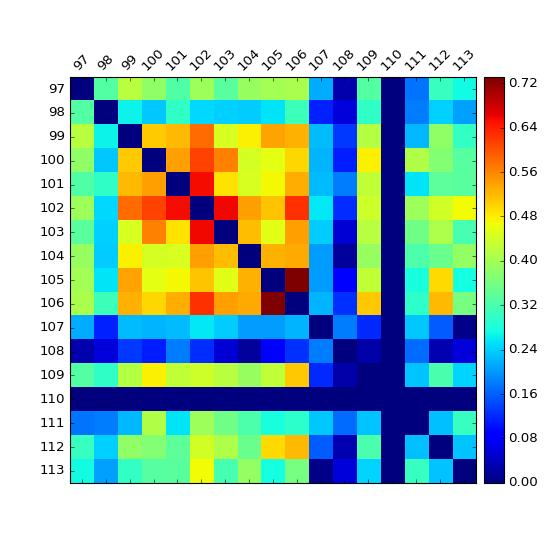

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
matshow = ax.matshow(corr_xy)

labels = [str(x) for x in range(97,114)]
plt.xticks(np.arange(0,17), rotation = 45)
plt.yticks(np.arange(0,17))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(matshow, cax=cax)



# Discussion and remarks
Looking at the correlation map, we can identify a highly correlated square, corresponding to the areas [99-106]. If we look at the blue print, the areas [97-104] are phisically close to each other, whereas the areas 105 and 106 seems to be the exits.

As stated earlier, we can see that the the areas corresponding to the bottom part of the store (the square corresponding to the areas [108-113]) does not present strong correlations, despite being phisically close to each other. Also, the areas 98 and 108 show overall low correlation with all areas.

Dispite the raw data available, the proposed metric reflects, in some level, the shoppers' positional behaviour in time. Revealing valuable information about the effectiveness of the products arrengement which leverages on better planning promotional offers, for example.